## Re-run of re-tweet (predictive) analyses using new data from David

In [1]:
# hide warnings to keep things tidy.
import warnings
warnings.filterwarnings('ignore')

import json
from pprint import pprint

import pandas as pd
import numpy as np 
import scipy as sp
import nltk
import sklearn
import statsmodels 
from statsmodels.graphics.api import abline_plot
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline 

import snowball


In [2]:
with open("updated_tweets.json") as updated_tweets_f:
    # the transpose is to re-shape so that rows are
    # tweets (cols are attributes)
    tweet_df = pd.read_json(updated_tweets_f).T

In [3]:
len(tweet_df)

13484

In [4]:
tweet_df.head()

,contributors,coordinates,created_at,entities,extended_entities,favorite_count,favorited,geo,id,id_str,...,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,text,truncated,user
1975-11-13 00:33:36.092880896,None,None,Wed Mar 28 18:28:15 +0000 2012,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,0,False,None,185070816092880896,185070816092880896,...,NaN,NaN,NaN,0,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Just informed by a 26 year old Human papillom...,False,"{'has_extended_profile': False, 'listed_count'..."
1975-11-13 07:38:08.109461507,None,None,Wed Mar 28 20:09:28 +0000 2012,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,0,False,None,185096288109461507,185096288109461507,...,NaN,NaN,NaN,0,False,NaN,"<a href=""http://www.facebook.com/twitter"" rel=...",MsRhea Mike\n\n HEALTHY Wednesday Awareness\n ...,False,"{'has_extended_profile': False, 'listed_count'..."
1975-11-14 05:10:19.793735680,None,None,Thu Mar 29 01:17:33 +0000 2012,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,0,False,None,185173819793735680,185173819793735680,...,NaN,NaN,NaN,1,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","If someone tells you that ""everybody"" has HPV ...",False,"{'has_extended_profile': False, 'listed_count'..."
1975-11-16 15:35:26.382215169,None,None,Thu Mar 29 15:13:14 +0000 2012,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,0,False,None,185384126382215169,185384126382215169,...,NaN,NaN,NaN,0,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",@vester71 pap smear?,False,"{'has_extended_profile': False, 'listed_count'..."
1975-11-16 19:23:57.574582272,None,None,Thu Mar 29 16:07:43 +0000 2012,"{'hashtags': [{'indices': [21, 24], 'text': 'x...",NaN,0,False,None,185397837574582272,185397837574582272,...,NaN,NaN,NaN,0,False,NaN,"<a href=""http://twitter.com/download/android"" ...",@maja_berge gardasil?#x1,False,"{'has_extended_profile': False, 'listed_count'..."


In [5]:
tweet_df.columns

Index(['contributors', 'coordinates', 'created_at', 'entities',
       'extended_entities', 'favorite_count', 'favorited', 'geo', 'id',
       'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'place',
       'possibly_sensitive', 'quoted_status', 'quoted_status_id',
       'quoted_status_id_str', 'retweet_count', 'retweeted',
       'retweeted_status', 'source', 'text', 'truncated', 'user'],
      dtype='object')

### Note that the "retweeted" flag is *uniformly* False in this dataset.

In [6]:
primary_tweets = tweet_df[tweet_df["retweeted"] == False]
retweets = tweet_df[tweet_df["retweeted"] == True]
print("# primary tweets: %s; # retweets: %s" % (
        len(primary_tweets), len(retweets)))

# primary tweets: 13484; # retweets: 0


### Here I try and predict the number of retweets as a function of the number of followers one has. 

Assumptions and caveats: 
* The number of followers of the user who issued the *original* tweet is in the field 'retweeted_status':'user':''followers_count'. But note that often the retweeted_status is missing! e.g., see immediately below.

* Furthermore, 


In [7]:
pd.isnull(primary_tweets["retweeted_status"].values[0])

True

In [8]:
# grab the tweets for which 'retweeted_status' is NOT NaN.
retweeted_status_tweets = primary_tweets[pd.notnull(primary_tweets["retweeted_status"])]

Looks like we've got ~4000 of these.

In [9]:
retweeted_status_tweets.shape

(4003, 29)

In [10]:
retweet_statuses = retweeted_status_tweets["retweeted_status"]

In [11]:
X,y = [], []
for retweet_status in retweet_statuses:
    X.append(retweet_status["user"]["followers_count"])
    y.append(retweet_status["retweet_count"])

I print out stats below; note that (apparently) the mean number of followers here is 580243! This seems (suspiciously) large to me? The range is (12, 2.4 mil).

In [12]:
print(sp.stats.describe(X))

DescribeResult(nobs=4003, minmax=(12, 24351297), mean=580243.18236322759, variance=4096598958980.5522, skewness=6.492507656557192, kurtosis=56.436307988424254)


Re-tweet counts, meanwhile, seem sane.

In [13]:
print(sp.stats.describe(y))

DescribeResult(nobs=4003, minmax=(1, 1588), mean=69.985011241568827, variance=46464.207671332952, skewness=4.976284326773306, kurtosis=26.46980446858595)


In [14]:
# prepare data for statsmodels
X = np.matrix(X).T
y = np.array(y)
print("X shape: %s; y shape: %s" % (X.shape, y.shape))

X shape: (4003, 1); y shape: (4003,)


Now fit the model; again this is just using the raw number of followers as the independent var and the retweet count as the dependent.

In [15]:
user_model = sm.OLS(y, sm.add_constant(X, prepend=True))
user_only_results = user_model.fit()
print(user_only_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     577.4
Date:                Tue, 01 Mar 2016   Prob (F-statistic):          2.66e-119
Time:                        10:28:03   Log-Likelihood:                -26919.
No. Observations:                4003   AIC:                         5.384e+04
Df Residuals:                    4001   BIC:                         5.385e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         48.0393      3.314     14.498      0.0

So this looks far saner than the previous results; the number of followers has a slight positive correlation with the number of retweets. 

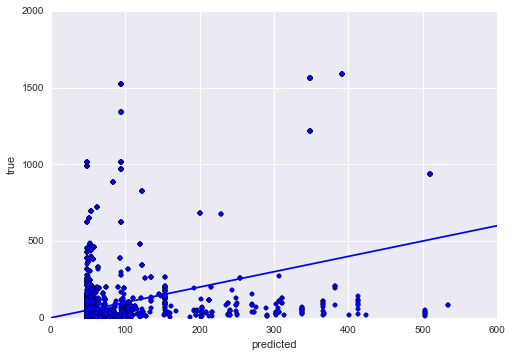

In [16]:
yhat = user_only_results.fittedvalues
fig, ax = plt.subplots()
ax.scatter(yhat, y)
ax.set_xlabel("predicted")
ax.set_ylabel("true")
ax.set_ylim((0,2000))
ax.set_xlim((0,600)) # excluding some outliers here
line_fit = sm.OLS(y,sm.add_constant(yhat, prepend=True)).fit()
fitted_plot = abline_plot(model_results=line_fit, ax=ax)

Now introduce text features (simple unigrams for now) as well. Because we only have 4k examples here, I severely limit predictor set (to 500 most frequent words).

In [17]:
## 
# build text features. 
vectorizer = sklearn.feature_extraction.text.CountVectorizer(binary=True, 
                                        stop_words="english", max_features=500, min_df=5)
X_text = vectorizer.fit_transform(retweeted_status_tweets["text"])
X_text.shape

(4003, 500)

In [18]:
# build
X_all  = X_text.copy().todense()
X_user_normed = X/X.max()
X_user_normed = sm.add_constant(X_user_normed, prepend=True)
X_all  = np.hstack((X_user_normed, X_all))

In [19]:
indices_to_tokens = dict(zip(list(vectorizer.vocabulary_.values()), list(vectorizer.vocabulary_)))

In [20]:
X_all_df = pd.DataFrame(X_all)
words = [indices_to_tokens[idx] for idx in range(X_text.shape[1])]
col_names = ["intercept", "followers"]
col_names.extend(words)
X_all_df.columns = col_names

In [21]:
model_all = sm.OLS(y, X_all_df)
results_all = model_all.fit()
print(results_all.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     36.87
Date:                Tue, 01 Mar 2016   Prob (F-statistic):               0.00
Time:                        10:28:04   Log-Likelihood:                -23547.
No. Observations:                4003   AIC:                         4.808e+04
Df Residuals:                    3510   BIC:                         5.118e+04
Df Model:                         492                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
intercept        -1.143e+15    5.4e+14  

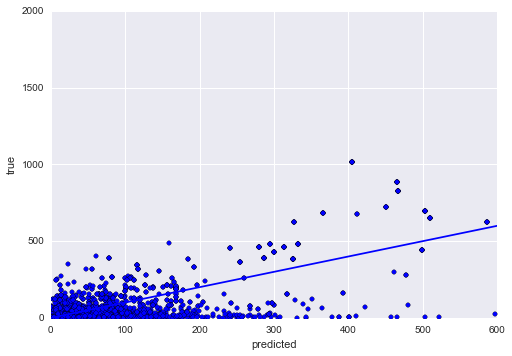

In [22]:
yhat = results_all.fittedvalues
fig, ax = plt.subplots()
ax.scatter(yhat, y)
ax.set_xlabel("predicted")
ax.set_ylabel("true")
ax.set_ylim((0,2000))
ax.set_xlim((0,600)) # excluding some outliers here
line_fit = sm.OLS(y,sm.add_constant(yhat, prepend=True)).fit()
fitted_plot = abline_plot(model_results=line_fit, ax=ax)

A note of caution, of course: this is certainly overfit! We have 500+ predictors and only 4k data points, so results to be taken with a large grain of salt.